#### **1. Import Library yang Dibutuhkan**


In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [58]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 8.2 MB/s eta 0:00:00


In [81]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,Attention,Layer, Input
from tensorflow.keras import layers, models, regularizers
import matplotlib.pyplot as plt
import os
from tensorflow import keras
from keras_tuner import RandomSearch

#### 2. Ekstrak Dataset dari File Zip

In [82]:
# !unzip /content/drive/MyDrive/facial_expression_recognition/data.zip -d extracted_data/


#### 3. Load CSV File untuk Label

In [83]:
label_file_path = 'extracted_data/labels.csv'
df_labels = pd.read_csv(label_file_path)
df_labels.columns

Index(['Unnamed: 0', 'pth', 'label', 'relFCs'], dtype='object')

In [84]:
base_dir = 'extracted_data'
print(base_dir)
df_labels.head(5)

extracted_data


,Unnamed: 0,pth,label,relFCs
0,0,anger/image0000006.jpg,surprise,0.873142
1,1,anger/image0000060.jpg,anger,0.852311
2,2,anger/image0000061.jpg,anger,0.800957
3,3,anger/image0000066.jpg,disgust,0.843079
4,4,anger/image0000106.jpg,anger,0.849108


In [85]:
image_paths = df_labels['pth']
print(image_paths.head())

0    anger/image0000006.jpg
1    anger/image0000060.jpg
2    anger/image0000061.jpg
3    anger/image0000066.jpg
4    anger/image0000106.jpg
Name: pth, dtype: object


In [86]:
labels = df_labels['label']
print(labels.unique())  # Melihat berbagai label yang ada


['surprise' 'anger' 'disgust' 'fear' 'sad' 'contempt' 'neutral' 'happy']


In [87]:
df_labels.drop(columns=['Unnamed: 0'])

,pth,label,relFCs
0,anger/image0000006.jpg,surprise,0.873142
1,anger/image0000060.jpg,anger,0.852311
2,anger/image0000061.jpg,anger,0.800957
3,anger/image0000066.jpg,disgust,0.843079
4,anger/image0000106.jpg,anger,0.849108
...,...,...,...
28170,surprise/image0034960.jpg,surprise,0.825263
28171,surprise/image0034961.jpg,surprise,0.738646
28172,surprise/image0034966.jpg,surprise,0.774524
28173,surprise/image0034973.jpg,neutral,0.766952


In [88]:
image_paths = df_labels['pth'].values
labels = df_labels['label'].values


#### Preprocessing

In [89]:
def random_erasing(image, prob=0.5, area_ratio=(0.02, 0.33)):
    """Randomly erase a part of the image."""
    if tf.random.uniform(()) < prob:
        img_shape = tf.shape(image)
        h, w = img_shape[0], img_shape[1]
        area = tf.cast(h * w, tf.float32)

        # Randomly select the size of the erased area
        for _ in range(10):  # try 10 times
            target_area = tf.random.uniform(
                (), minval=area * area_ratio[0], maxval=area * area_ratio[1]
            )
            aspect_ratio = tf.random.uniform((), 0.3, 3.3)

            h_erase = tf.cast(tf.math.sqrt(target_area * aspect_ratio), tf.int32)
            w_erase = tf.cast(tf.math.sqrt(target_area / aspect_ratio), tf.int32)

            # Randomly select the position of the erased area
            y = tf.random.uniform((), 0, h - h_erase, dtype=tf.int32)
            x = tf.random.uniform((), 0, w - w_erase, dtype=tf.int32)

            # Create a mask for erasing
            mask = tf.zeros((h_erase, w_erase, 3), dtype=image.dtype)
            image = tf.tensor_scatter_nd_update(image, [[y + i, x + j] for i in range(h_erase) for j in range(w_erase)], mask.numpy().flatten())
            return image

    return image

class CustomImageDataGenerator(ImageDataGenerator):
    def flow(self, *args, **kwargs):
        for batch in super().flow(*args, **kwargs):
            yield self._augment_batch(batch)

    def _augment_batch(self, batch):
        for i in range(batch.shape[0]):
            batch[i] = random_erasing(batch[i])
        return batch


train_datagen = CustomImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)



In [90]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_labels,
    directory=base_dir,
    x_col='pth',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

Found 22540 validated image filenames belonging to 8 classes.


In [91]:
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=df_labels,
    directory=base_dir,
    x_col='pth',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 5635 validated image filenames belonging to 8 classes.


Batch size (jumlah gambar): (32, 96, 96, 3)
Label shape: (32, 8)


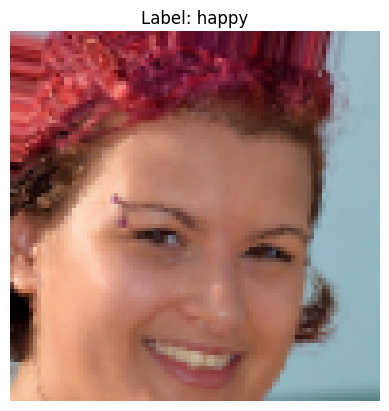

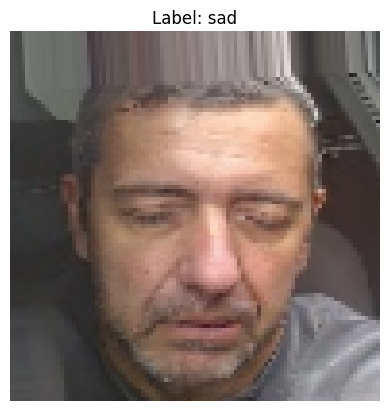

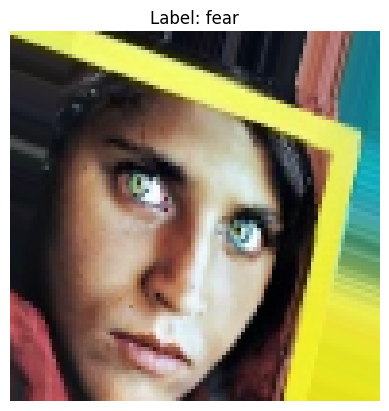

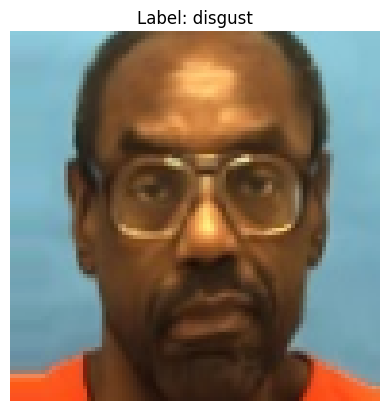

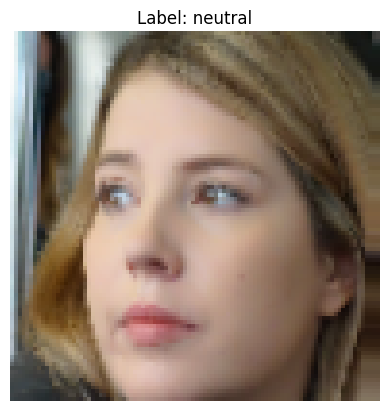

In [92]:
images, labels = next(train_generator)

print("Batch size (jumlah gambar):", images.shape)
print("Label shape:", labels.shape)

batch_labels = np.argmax(labels, axis=1)

class_names = train_generator.class_indices
class_names = {v: k for k, v in class_names.items()}


for i in range(5):
    plt.imshow(images[i])
    plt.title(f"Label: {class_names[batch_labels[i]]}")
    plt.axis('off')
    plt.show()


In [98]:
from keras_tuner import HyperParameters
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Membuat bobot W untuk layer perhatian
        self.W = self.add_weight(name='W',
                                  shape=(input_shape[-1], input_shape[-1]),
                                  initializer='random_normal',
                                  trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # Menghitung perhatian menggunakan tf.matmul
        Q = tf.matmul(inputs, self.W)  # Menghitung Q
        A = tf.nn.softmax(Q)            # Menghitung Attention Weight
        return A * inputs                # Mengembalikan hasil perhatian

    def compute_output_shape(self, input_shape):
        return input_shape

In [99]:

def create_model(hp):

    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    num_neurons = hp.Int('num_neurons', min_value=64, max_value=512, step=64)

    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(AttentionLayer())

    model.add(layers.Flatten())
    model.add(layers.Dense(num_neurons, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))  # L2 Regularization
    model.add(layers.Dropout(dropout_rate))  # Dropout
    model.add(layers.Dense(len(df_labels['label'].unique()), activation='softmax'))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [ ]:
tuner = RandomSearch(
    create_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='tuner_results',
    project_name='face_expression_recognition'
)

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

tuner.search(train_generator, epochs=30, validation_data=validation_generator, callbacks=[stop_early])


best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()


In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)


In [ ]:
loss, accuracy = model.evaluate(validation_generator)
print(f"Loss: {loss}, Accuracy: {accuracy}")

In [ ]:
# from tensorflow.keras.applications import VGG16

# # Menggunakan VGG16 sebagai backbone
# base_model = VGG16(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# # Membekukan semua layer pada model dasar
# for layer in base_model.layers:
#     layer.trainable = False

# # Membangun model baru
# model = Sequential()
# model.add(base_model)
# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(len(df_labels['label'].unique()), activation='softmax'))

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
